<a href="https://colab.research.google.com/github/andyrids/trackinsight/blob/main/trackinsight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install haversine mapclassify folium -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.1 MB/s eta 0:00:00


In [13]:
import concurrent.futures
import functools
import io
import multiprocessing
import pathlib
import zipfile

from typing import Iterable

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from geopandas import GeoDataFrame
from haversine import haversine_vector, Unit
from numpy.typing import ArrayLike, NDArray
from pandas import DataFrame, DatetimeIndex
from scipy.interpolate import pchip_interpolate

In [ ]:
# sort array
# a = a[a[:, 0].argsort()]

In [ ]:
# [[t, x, y], ...]
# np.split(a[:,1], np.unique(a[:, 0], return_index=True)[1][1:])

In [3]:
def sort_trajectories(
        data: DataFrame,
        uid_column: str = "ti_uid",
        time_column: str = "ti_timestamp"
    ) -> DataFrame:
    """Sort trajectories by unique identifier & timestamp."""
    return data.sort_values(by=[uid_column, time_column]).reset_index(drop=True)

In [4]:
def assign_epoch_time(data: DataFrame, time_column: str = "ti_timestamp") -> DataFrame:
    """"""
    return data.assign(
        ti_timestamp=DatetimeIndex(data[time_column]).asi8 // 10**9
    )

In [5]:
def assign_elapsed_seconds(
        data: DataFrame,
        time_column: str = "ti_timestamp"
    ) -> DataFrame:
    """Calculate elapsed seconds between trajectory points.

    Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        time_column (str): Timestamp column.

    Returns:
        A DataFrame with a `ti_elapsed_time_s` column containing
        the elapsed time between trajectory points in seconds.
    """
    elapsed_time_s = data[time_column].diff()
    return data.assign(ti_elapsed_time_s=elapsed_time_s)

In [6]:
def assign_elapsed_distance(
        data: DataFrame,
        latitude_column: str = "ti_latitude",
        longitude_column: str = "ti_longitude"
    ) -> DataFrame:
    """Calculate the distance travelled between trajectory points.

    Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        x_column (str): X-coordinate column.
        y_column (str): Y-coordinate column.

    Returns:
        A DataFrame with a `ti_distance_m` column, containing the
        distance travelled between trajectory points in meters.
    """
    latlong_columns = [latitude_column, longitude_column]
    distance_m = haversine_vector(
        data[latlong_columns], data[latlong_columns].shift(), Unit.METERS, check=False
    )

    return data.assign(ti_distance_m=distance_m)

In [7]:
def assign_calculated_speed(
    data: DataFrame,
    elapsed_time_column: str = "ti_elapsed_time_s",
    elapsed_distance_column: str = "ti_distance_m"
) -> DataFrame:
    """Calculate the speed between trajectory points.

    NOTE: Speeds are calculated in m/s & Kn.

    Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        elapsed_time_column (str): Elapsed time column.
        elapsed_distance_column (str): Elapsed distance column.

    Returns:
       A DataFrame with `ti_speed_mps` & `ti_speed_kts`
       speed columns.
    """
    speed_mps = data[elapsed_distance_column] / data[elapsed_time_column]
    speed_kts = speed_mps * 1.943844
    return data.assign(ti_speed_mps=speed_mps, ti_speed_kts=speed_kts)

In [8]:
def convert_to_geodataframe(
        data: DataFrame,
        latitude_column: str = "ti_latitude",
        longitude_column: str = "ti_longitude",
        crs: str = "EPSG:4326"
    ) -> GeoDataFrame:
    """Convert trajectory data to a GeoDataFrame.

        Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        latitude_column (str): Latitude column.
        longitude_column (str): Longitude column.

    Returns:
        A GeoDataFrame.
    """
    geometry = gpd.points_from_xy(data[longitude_column], data[latitude_column], crs=crs)
    geometry_3857 = geometry.to_crs(epsg=3857)
    data = data.assign(geometry=geometry, geometry_3857=geometry_3857)
    return GeoDataFrame(data, geometry="geometry")

In [9]:
def transform_trajectories(
    data: DataFrame,
    uid_column: str,
    datetime_column: str,
    latitude_column: str,
    longitude_column: str,
) -> DataFrame:
    """Transform AIS trajectory data.

    Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        datetime_column (str): Datetime64 column.
        latitude_column (str): Latitude column.
        longitude_column (str): Longitude column.

    Returns:
        A DataFrame with transformed trajectory data.
    """
    if data[datetime_column].dtype.name.startswith("datetime64"):
        data = data.pipe(assign_epoch_time, datetime_column)
        timestamp_column = "ti_timestamp"
    else:
        raise ValueError(f"Unsupported time column type: {data[datetime_column].dtype}")

    columns = (uid_column, datetime_column, timestamp_column, latitude_column, longitude_column)
    data = data.filter(columns)

    ti_columns = ("ti_uid", "ti_datetime", "ti_timestamp", "ti_latitude", "ti_longitude")
    data = data.set_axis(ti_columns, axis="columns")

    grouped = data.groupby("ti_uid", as_index=False, group_keys=False)
    data = grouped[data.columns].apply(lambda x:
        x
        .pipe(sort_trajectories)
        .pipe(assign_elapsed_seconds)
        .pipe(assign_elapsed_distance)
        .pipe(assign_calculated_speed)
    )

    return data

In [10]:
r = requests.get("https://figshare.com/ndownloader/files/16442771")

In [11]:
zf = zipfile.ZipFile(io.BytesIO(r.content))

In [12]:
zf.extractall(path="data")

In [14]:
def read_csv_files(path: pathlib.Path) -> DataFrame:
    data = pd.read_csv(path, sep=";")
    return data.assign(uid=path.stem)


def process_file(path: pathlib.Path) -> DataFrame | None:
    try:
        return read_csv_files(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

In [15]:
num_processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=num_processes) as pool:
    results = pool.map(process_file, pathlib.Path("data/data").glob("*.txt"))

dataframes = filter(lambda x: isinstance(x, DataFrame), results)

In [16]:
data = (
    pd.concat(dataframes)
    .assign(t=lambda x: pd.to_timedelta(x["t"], unit="s"))
    .assign(datetime=lambda x: pd.to_datetime("now") + x["t"])
    .filter(("uid", "x", "y", "datetime"), axis="columns")
)

*   **x** is the longitude (in degrees)

*   **y** is the latitude (in degrees)

*   **vx** is the x-velocity (in knots) given in the AIS message (not computed from positions and time)

*   **vy** is the y-velocity (in knots) given in the AIS message (not computed from positions and time)

*   **t** the time since the beginning of the trajectory (in seconds).

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7131993 entries, 0 to 214
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   uid       object        
 1   x         float64       
 2   y         float64       
 3   datetime  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 272.1+ MB


In [18]:
ti_data = transform_trajectories(data, "uid", "datetime", "y", "x")
ti_data

,ti_uid,ti_datetime,ti_timestamp,ti_latitude,ti_longitude,ti_elapsed_time_s,ti_distance_m,ti_speed_mps,ti_speed_kts
0,traj_1,2025-01-30 20:39:50.275132,1738269590,48.405752,-5.945927,NaN,NaN,NaN,NaN
0,traj_10,2025-01-30 20:39:50.275132,1738269590,49.161545,-4.313233,NaN,NaN,NaN,NaN
0,traj_100,2025-01-30 20:39:50.275132,1738269590,48.513152,-5.837035,NaN,NaN,NaN,NaN
0,traj_1000,2025-01-30 20:39:50.275132,1738269590,48.295513,-5.988233,NaN,NaN,NaN,NaN
0,traj_10000,2025-01-30 20:39:50.275132,1738269590,48.130433,-5.365750,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
31055,traj_3083,2025-02-06 13:12:19.275132,1738847539,48.748267,-4.502645,2637.0,7195.948135,2.728839,5.304437
31056,traj_3083,2025-02-06 13:13:20.275132,1738847600,48.748723,-4.500458,61.0,168.171974,2.756918,5.359018
31057,traj_3083,2025-02-06 13:15:08.275132,1738847708,48.749518,-4.496473,108.0,305.249968,2.826389,5.494059
31058,traj_3083,2025-02-06 13:30:09.275132,1738848609,48.757330,-4.465023,901.0,2463.825248,2.734545,5.315529


In [106]:
gdf_ti_data = convert_to_geodataframe(ti_data.query("ti_uid.isin(['traj_1', 'traj_2', 'traj_3', 'traj_4', 'traj_100'])"))
gdf_ti_data = gdf_ti_data.assign(buffer=lambda x: x["geometry_3857"].buffer(2000, cap_style="square").to_crs(4326))
gdf_ti_data

,ti_uid,ti_datetime,ti_timestamp,ti_latitude,ti_longitude,ti_elapsed_time_s,ti_distance_m,ti_speed_mps,ti_speed_kts,geometry,geometry_3857,buffer
0,traj_1,2025-01-30 20:39:50.275132,1738269590,48.405752,-5.945927,NaN,NaN,NaN,NaN,POINT (-5.94593 48.40575),POINT (-661897.529 6174624.88),"POLYGON ((-5.92796 48.41768, -5.92796 48.39382..."
0,traj_100,2025-01-30 20:39:50.275132,1738269590,48.513152,-5.837035,NaN,NaN,NaN,NaN,POINT (-5.83704 48.51315),POINT (-649775.764 6192653.562),"POLYGON ((-5.81907 48.52505, -5.81907 48.50125..."
0,traj_2,2025-01-30 20:39:50.275132,1738269590,48.179667,-6.070000,NaN,NaN,NaN,NaN,POINT (-6.07 48.17967),POINT (-675709.309 6136797.185),"POLYGON ((-6.05203 48.19165, -6.05203 48.16769..."
0,traj_3,2025-01-30 20:39:50.275132,1738269590,47.075325,-6.903405,NaN,NaN,NaN,NaN,POINT (-6.9034 47.07532),POINT (-768483.529 5954377.708),"POLYGON ((-6.88544 47.08756, -6.88544 47.06309..."
0,traj_4,2025-01-30 20:39:50.275132,1738269590,47.787890,-6.374520,NaN,NaN,NaN,NaN,POINT (-6.37452 47.78789),POINT (-709608.32 6071639.553),"POLYGON ((-6.35655 47.79996, -6.35655 47.77582..."
...,...,...,...,...,...,...,...,...,...,...,...,...
763,traj_1,2025-01-31 01:38:43.275132,1738287523,49.179333,-4.615412,13.0,88.071144,6.774703,13.168966,POINT (-4.61541 49.17933),POINT (-513785.277 6305345.472),"POLYGON ((-4.59745 49.19108, -4.59745 49.16759..."
764,traj_1,2025-01-31 01:39:12.275132,1738287552,49.180313,-4.612897,29.0,212.822042,7.338691,14.265271,POINT (-4.6129 49.18031),POINT (-513505.308 6305512.361),"POLYGON ((-4.59493 49.19206, -4.59493 49.16857..."
765,traj_1,2025-01-31 01:41:00.275132,1738287660,49.183895,-4.603510,108.0,789.991281,7.314734,14.218702,POINT (-4.60351 49.1839),POINT (-512460.389 6306122.328),"POLYGON ((-4.58554 49.19564, -4.58554 49.17215..."
766,traj_1,2025-01-31 01:41:19.275132,1738287679,49.184498,-4.601963,19.0,130.909457,6.889971,13.393030,POINT (-4.60196 49.1845),POINT (-512288.215 6306225.082),"POLYGON ((-4.584 49.19624, -4.584 49.17275, -4..."


In [43]:
gdf_ti_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1083 entries, 0 to 767
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ti_uid             1083 non-null   object        
 1   ti_datetime        1083 non-null   datetime64[ns]
 2   ti_timestamp       1083 non-null   int64         
 3   ti_latitude        1083 non-null   float64       
 4   ti_longitude       1083 non-null   float64       
 5   ti_elapsed_time_s  1078 non-null   float64       
 6   ti_distance_m      1078 non-null   float64       
 7   ti_speed_mps       1078 non-null   float64       
 8   ti_speed_kts       1078 non-null   float64       
 9   geometry           1083 non-null   geometry      
 10  geometry_3857      1083 non-null   geometry      
 11  buffer             1083 non-null   geometry      
dtypes: datetime64[ns](1), float64(6), geometry(3), int64(1), object(1)
memory usage: 110.0+ KB


In [107]:
gdf_ti_data.set_geometry("buffer").explore()

In [34]:
import folium

In [42]:
style = """
background-color: white;
font-size: 18px;
font-family: Arial;
border: 2px solid black;
border-radius: 5px;
padding: 10px;
"""

gdf_ti_data.explore(
    "ti_uid",
    tiles="CartoDB dark_matter",
    popup=True,
    popup_kwds={"style": style},
    tooltip_kwds={"style": style},
)

In [138]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPoint, MultiPolygon
from shapely.ops import cascaded_union
from shapely import concave_hull

def concave_hull_segmentation(gdf, time_column='ti_datetime', buffer_column='buffer', uid_column='ti_uid'):
    # Ensure the time column is datetime
    gdf[time_column] = pd.to_datetime(gdf[time_column])

    # Group by hour and UID
    hourly_segments = gdf.groupby([pd.Grouper(key=time_column, freq='1h'), uid_column])

    concave_hulls = []
    for (hour, uid), group in hourly_segments:
        # Handle cases where there are no points in an hour
        if group.empty:
            continue

        # Combine buffered geometries within the hourly segment
        # combined_buffer = cascaded_union(group[buffer_column])

        combined_buffer = concave_hull(MultiPolygon(group[buffer_column].to_list()), ratio=1, allow_holes=False)

        # If the combined buffer is not a Polygon, skip
        if not isinstance(combined_buffer, Polygon):
            continue

        concave_hulls.append({
            'hour': hour,
            "min_time": f"{group['ti_datetime'].min():%H:%M:%S}",
            "max_time": f"{group['ti_datetime'].max():%H:%M:%S}",
            'uid': uid,
            'geometry': combined_buffer,
            'n_points': len(group)
        })

    return gpd.GeoDataFrame(concave_hulls, geometry='geometry', crs=gdf.crs)


In [139]:
# Example usage (assuming your GeoDataFrame is named gdf_ti_data):
concave_hulls_gdf = concave_hull_segmentation(gdf_ti_data)
print(concave_hulls_gdf.head())

m = gdf_ti_data.explore(
    "ti_uid",
    tiles="CartoDB dark_matter",
    popup=True,
    popup_kwds={"style": style},
    tooltip_kwds={"style": style},
)

# Plot the concave hulls (optional)
concave_hulls_gdf.explore("uid", m=m)

                 hour  min_time  max_time       uid  \
0 2025-01-30 20:00:00  20:39:50  20:57:27    traj_1   
1 2025-01-30 20:00:00  20:39:50  20:57:40  traj_100   
2 2025-01-30 20:00:00  20:39:50  20:56:33    traj_2   
3 2025-01-30 20:00:00  20:39:50  20:45:26    traj_3   
4 2025-01-30 20:00:00  20:39:50  20:39:50    traj_4   

                                            geometry  n_points  
0  POLYGON ((-5.93059 48.47028, -5.92286 48.48043...        17  
1  POLYGON ((-5.855 48.52505, -5.81026 48.57793, ...         5  
2  POLYGON ((-6.05203 48.16769, -6.08797 48.16769...         4  
3  POLYGON ((-6.92137 47.08756, -6.90576 47.11047...         2  
4  POLYGON ((-6.35655 47.77582, -6.39249 47.77582...         1  


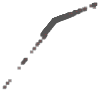

In [ ]:
concave_hull()

In [ ]:
distance_mask = ~ti_data["ti_speed_mps"].isin((np.nan, np.inf, -np.inf))
distances_m = ti_data["ti_distance_m"].to_numpy()[distance_mask]

# xi should be the cumulative distance
xi = np.cumsum(distances_m)

# yi should contain the columns you want to interpolate: latitude, longitude, and timestamp
yi = (
    ti_data
    .loc[distance_mask]
    .filter(["ti_latitude", "ti_longitude", "ti_speed_kts", "ti_timestamp"])
    .to_numpy()
)

resolution = 60
num = int(np.ceil(xi[-1] / 60))

x = np.linspace(xi[0], xi[-1], num=num, endpoint=True)
y = pchip_interpolate(xi, yi, x, axis=0)

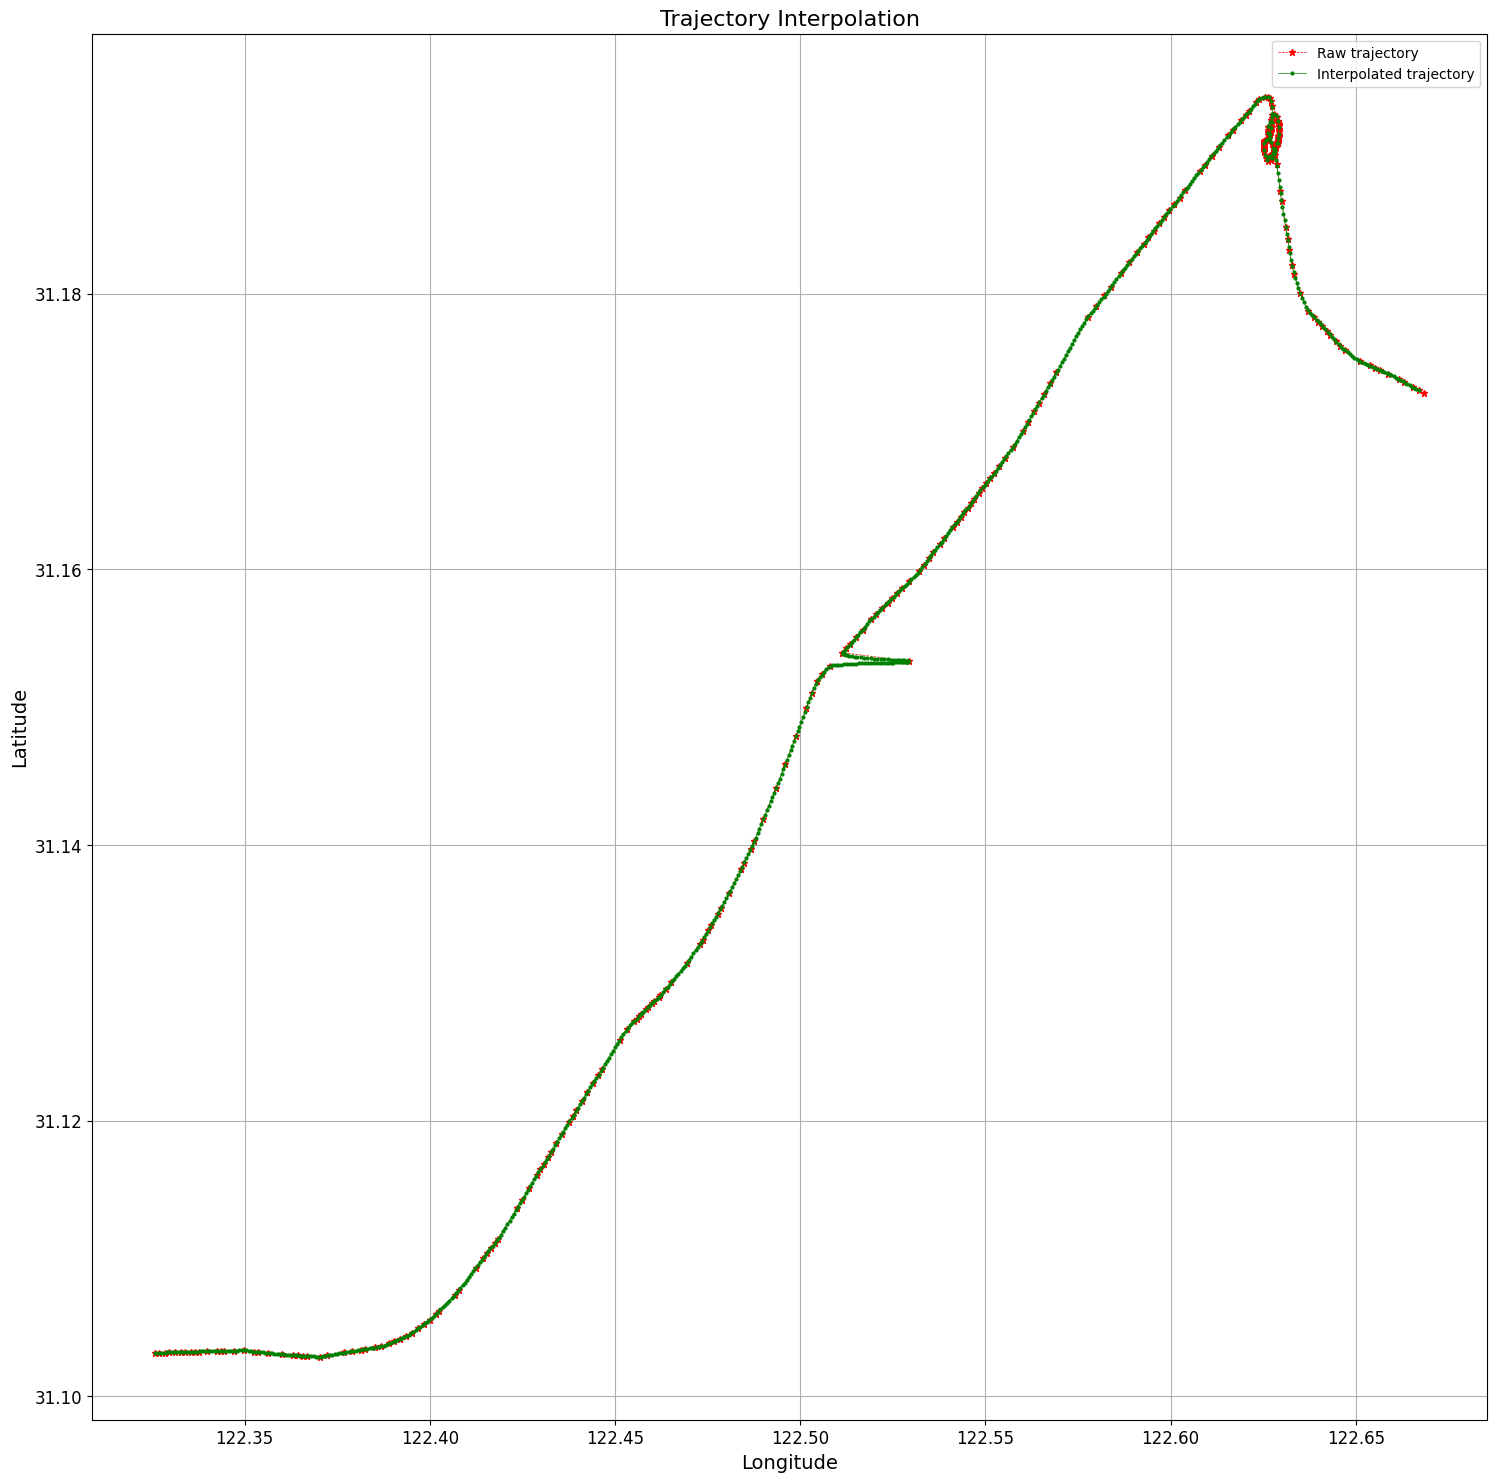

<Figure size 1800x1800 with 0 Axes>

In [ ]:
plt.figure(figsize=(18,18), dpi=100)

plt.plot(
    ti_data['ti_longitude'],
    ti_data['ti_latitude'],
    marker='*',
    ms=5,
    linestyle='--',
    color='red',
    linewidth=0.5,
    label='Raw trajectory'
)

plt.plot(
    y[:,1],
    y[:,0],
    marker='o',
    ms=2,
    linestyle='-',
    color='g',
    linewidth=0.5,
    label='Interpolated trajectory'
)

plt.yticks(size=12)
plt.xticks(size=12)
plt.xlabel('Longitude', fontdict={'size': 14})
plt.ylabel('Latitude', fontdict={'size': 14})
plt.title('Trajectory Interpolation', fontdict={'size': 16})
plt.ticklabel_format(useOffset=False, style='plain')
plt.grid()
plt.legend()
plt.figure(figsize=(18,18), dpi=100)
plt.tight_layout()
plt.show()

In [ ]:
gpd.GeoDataFrame(
    data=ti_data,
    geometry=gpd.points_from_xy(ti_data['ti_longitude'], ti_data['ti_latitude']),
    crs="EPSG:4326"
).explore()

In [ ]:
import pyproj
import shapely

In [ ]:
geometry = gpd.points_from_xy(data_transformed.ti_x, data_transformed.ti_y)
geo_data_transformed = gpd.GeoDataFrame(data_transformed, geometry=geometry, crs="EPSG:4326")

In [ ]:
geo_data_transformed

ti_timestamp        ti_x       ti_y  ti_elapsed_time_s  \
ti_uid                                                                  
244726000 0      1556415580  122.668333  31.172785                NaN   
          1      1556415599  122.667032  31.172983               19.0   
          2      1556415623  122.665447  31.173205               24.0   
          3      1556415659  122.662968  31.173597               36.0   
          4      1556415677  122.661732  31.173783               18.0   
...                     ...         ...        ...                ...   
          303    1556445869  122.331262  31.103215               30.0   
          304    1556445899  122.329603  31.103185               30.0   
          305    1556445920  122.328535  31.103173               21.0   
          306    1556445950  122.326922  31.103153               30.0   
          307    1556445969  122.325902  31.103155               19.0   

               ti_distance_m  ti_speed_mps  ti_speed_kts  \
ti_uid                                                     
244726000 0              NaN           NaN           NaN   
          1       125.782026      6.620107     12.868455   
          2       152.797062      6.366544     12.375569   
          3       239.780926      6.660581     12.947131   
          4       119.465403      6.636967     12.901228   
...                      ...           ...           ...   
          303     149.160800      4.972027      9.664844   
          304     157.930635      5.264354     10.233084   
          305     101.720586      4.843837      9.415664   
          306     153.617611      5.120587      9.953622   
          307      97.113893      5.111258      9.935487   

                                 geometry  
ti_uid                                     
244726000 0    POINT (122.66833 31.17278)  
          1    POINT (122.66703 31.17298)  
          2     POINT (122.66545 31.1732)  
          3     POINT (122.66297 31.1736)  
          4    POINT (122.66173 31.17378)  
...                                   ...  
          303  POINT (122.33126 31.10322)  
          304   POINT (122.3296 31.10318)  
          305  POINT (122.32854 31.10317)  
          306  POINT (122.32692 31.10315)  
          307   POINT (122.3259 31.10316)  

[308 rows x 8 columns]

In [ ]:
linestring = shapely.LineString(geo_data_transformed.geometry)

In [ ]:
# extracts the coordinates of all points in the linestrings and their corresponding linestring index
geom, index = shapely.get_coordinates(linestring, return_index=True)

In [ ]:
# trajectory points belowng to one segment Linestring (one index value)
index

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
geom.shape, geom[:-1, 0].shape

((308, 2), (307,))

In [ ]:
# creates a mask to handle cases where line segments might overlap
no_mix_mask = index[:-1] == index[1:]
no_mix_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
geo_data_transformed["ti_distance_m"].dropna()

ti_uid        
244726000  1      125.782026
           2      152.797062
           3      239.780926
           4      119.465403
           5      280.533425
                     ...    
           303    149.160800
           304    157.930635
           305    101.720586
           306    153.617611
           307     97.113893
Name: ti_distance_m, Length: 307, dtype: float64

array([1.25782026e+02, 1.52797062e+02, 2.39780926e+02, 1.19465403e+02,
       2.80533425e+02, 2.05772117e+02, 1.44699887e+02, 1.29376217e+02,
       2.47860479e+02, 3.93165001e+02, 1.52003300e+02, 1.11206298e+02,
       1.41254102e+02, 1.05485871e+02, 1.15273426e+02, 1.06691712e+02,
       1.15394115e+02, 1.63451211e+02, 2.43941970e+02, 2.23073733e+02,
       9.47399186e+01, 1.35829990e+02, 1.03624205e+02, 1.05667635e+02,
       2.34563656e+02, 8.87978456e+01, 2.33937870e+02, 8.40942508e+01,
       4.41838492e+01, 3.92871465e+01, 3.97137044e+01, 1.11810811e+02,
       2.29298598e+01, 1.06753698e+01, 8.56268755e+00, 2.82036725e+01,
       9.55548530e+01, 8.34437584e+01, 9.24105838e+01, 3.63026500e+01,
       1.29676905e+01, 8.35783403e+00, 2.39890571e+00, 3.39825114e+00,
       8.18918575e+00, 1.78216184e+00, 5.00883647e+00, 1.21950622e+01,
       2.45267791e+01, 1.85695784e-01, 2.82414359e+00, 3.86962288e+00,
       2.33828371e+00, 8.10790267e-01, 1.69229033e+01, 3.68816192e+01,
      

In [ ]:
%timeit geo_data_transformed["ti_distance_m"].sum()

32.5 µs ± 4.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
distances = geo_data_transformed["ti_distance_m"].dropna().to_numpy()
%timeit np.bincount((index[:-1])[no_mix_mask], weights=distances[no_mix_mask])

4.39 µs ± 127 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
